## Final Project Submission

Please fill out:
* Student name: Peter Vuong, Dara Estrada
* Student pace: Full time
* Scheduled project review date/time: 01/28/2022  
* Instructor name: Angelica Spratley & Diane Tunnicliffe
* Blog post URL:


In [74]:
# Your code here - remember to use markdown cells for comments as well!

# Why should Microsoft get into the movie industry?

There have been many popular IPs throughout the years such as Star Wars, Harry Potter, and more recently Iron Man and the inception of the Marvel Cinematic Universe. Marvel was able to enter a bustling movie industry with their tremendous success with the release of Iron Man, and since they have such massive collection of various IPs, their success has just cascaded from there. 
Similarly with just a little more work and resources, Microsoft (with their newly acquired IPs from their recent merge Activision Blizzard) will be able to enter the movie industry with a strong foot in the door. 

## Business Problem
We used this data to identify three main factors that were key to a movie's success in the industry:
* **Movie studio competition**
* **Most profitable movie genre**
* **Best Release season**

We believe that it is important for Microsoft to know these factors because understanding the competitors in this competitive market is important to gauge success. The genres of movies to be released is also very important as well. Microsoft shouldn't be releasing Musical movies if the market is trending towards Adventure/Animation movies(not to mention their IPs are not very musical oriented). Release timing of the movie is just as important of a factor to Microsoft's success. Releasing an Action movie during the summer might have more of a profit than releasing that same movie during the fall (it's called a summer blockbuster for a reason right?).

## Data Understanding & Exploring Data

Imported the appropriate libraries to be used for this data exploration and analysis

In [ ]:
import pandas as pd
import gzip as gz
import matplotlib.pyplot as plt
import sqlite3
import os
import zipfile
import seaborn as sns
import math
import numpy as np

We used a few databases that were available in the zippedData folder. We primarily utilized the im.db, tmdb.movies.csv, tn.movie_budgets.csv, and the bom.movie_gross.csv files to complete our data exploration and 
analysis. We looked at the necessary info and format to see if there was any missing data, data types, or ways to join the data.

In [ ]:
# Opened the relevant datasets to be explored in jupyter notebook
with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
    zipfile.ZipFile.extractall(my_zip,path='zippedData/')
with gz.open('zippedData/rt.reviews.tsv.gz') as f:
    rt_reviews = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/rt.movie_info.tsv.gz') as f:
    rt_movie_info = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/tmdb.movies.csv.gz') as f:
    tmdb_movies = pd.read_csv(f)
with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)
with gz.open('zippedData/bom.movie_gross.csv.gz') as f:
    bom_movie_gross = pd.read_csv(f)

In [ ]:
# Connected to im_db to utilize data and created a SQL query to pull information from the tables in their respective databases
im_db = sqlite3.connect('zippedData/im.db')
im_db_basics = pd.read_sql("""SELECT * FROM movie_basics""",im_db)
im_db_ratings = pd.read_sql("""SELECT * FROM movie_ratings""",im_db)
im_db_persons = pd.read_sql("""SELECT * FROM persons""",im_db)
im_db_principals = pd.read_sql("""SELECT * FROM principals""",im_db)

In [ ]:
# Created a SQL query to pull director name and info from the imdb database
director_info = """
SELECT
    m.movie_id,
    m.primary_title,
    m.genres,
    d.person_id,
    p.primary_name,
    p.death_year
    
    
FROM
    movie_basics AS m
    JOIN 
        directors AS d ON m.movie_id = d.movie_id
    JOIN
        known_for AS kf ON m.movie_id = kf.movie_id
    JOIN
        persons AS p ON p.person_id = d.person_id
GROUP BY
    m.movie_id, kf.person_id, p.primary_name
;
"""
director_info_result = pd.read_sql(director_info, im_db)
director_info_result

In [ ]:
director_info_result.info()

Initially we wanted to pull the information from the director's tables to find a correlation between movie revenue and directors, but once we merged all the data together we discovered that there was a lot of missing data for the domestic directors. We noted that in our observations and decided to move forward with looking at the studios instead.

In [ ]:
tn_movie_budgets.info()

In [ ]:
bom_movie_gross.info()

In [ ]:
# Created a new variable that filtered the director_info_results to drop all director's who are deceased
# and to drop any duplicate movie_ids 
clean_director_info = director_info_result[director_info_result['death_year'].isnull()].drop_duplicates(['primary_title'])

## Feature Engineering

Merged all the datasets together based on their movie title and cleaned up any junk/missing data that was present after merging the data sets. We created columns for `clean_budget`, `clean_domestic`, `clean_worldwide`, `clean_foreign`, `roi_domestic`, `roi_worldwide`, `clean_profit`, `studio`, and `Seasons`.


First, we took a look at the data from 'tn_movie_budgets.csv'. This data contains a release date and budget as well as domestic and worldwide revenue for each movie. The financials are in string form with punctuation, but we converted them to integers so that we can perform mathematical operations later. We can also determine the foreign revenue from the domestic and worldwide numbers. Finally, we kept only the relevant columns so that we can merge the data with the other sets later. 

In [83]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype('int64')
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)
#tn_movie_budgets.info()
tn_relevant_cols = ['title','year','month','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn_relevant = tn_movie_budgets[tn_relevant_cols]
#tn_relevant.head()

Next, we look at the data from `bom_movie_gross.csv`. This data is similar to the `tn_movie_budgets.csv`, but it has foreign revenue instead of worldwide, and it does not contain budget data. To make it easier for us to join the datasets, we converted all the financials to integers in order to calculate the foreign revenue from domestic and worldwide. Once again we only keep relevant columns.

In [84]:
bom_movie_gross['foreign_gross'] = bom_movie_gross['foreign_gross'].fillna('0')
bom_movie_gross.dropna(inplace=True)
bom_movie_gross['clean_domestic'] = bom_movie_gross['domestic_gross'].astype(int)
bom_movie_gross['clean_foreign'] = bom_movie_gross['foreign_gross'].str.replace(',','').astype(float)
bom_movie_gross['clean_foreign'] = bom_movie_gross['clean_foreign'].apply(math.trunc)
bom_movie_gross['clean_worldwide'] = bom_movie_gross['clean_domestic'] + bom_movie_gross['clean_foreign']
#bom_movie_gross.info()
bom_relevant_cols = ['title','year','clean_domestic','clean_foreign','clean_worldwide', 'studio']
bom_relevant = bom_movie_gross[bom_relevant_cols]
#bom_relevant.head()

Here we combine the two financial data sets from before keeping only one entry for the movies present in both datasets. We decided to apply the median budget for the movies that did not have budget information in the datasets because only about 1/4 of the data does not have budget information. We then calculated total profit and return on investment for each movie in the dataset.

In [85]:
combined_financials = pd.concat([tn_relevant,bom_relevant],ignore_index=True)
combined_financials = combined_financials.drop_duplicates(subset='title',keep='first')
#combined_financials.plot('clean_domestic','clean_foreign',kind='scatter')

#Much of the budget column is empty because bom_movie_gross does not include budget information
#Going to fill the NA budgets with the median value
combined_financials['clean_budget'].fillna(combined_financials['clean_budget'].median(),inplace=True)
combined_financials['roi_domestic'] = 100 * (combined_financials['clean_domestic'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['roi_worldwide'] = 100 * (combined_financials['clean_worldwide'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['clean_profit'] = combined_financials['clean_worldwide'] - combined_financials['clean_budget']
combined_financials.head()
combined_financials.describe()

,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_domestic,roi_worldwide,clean_profit
count,7.818000e+03,7.818000e+03,7.818000e+03,7.818000e+03,7818.000000,7818.000000,7.818000e+03
mean,2.779707e+07,3.327278e+07,4.192367e+07,7.519645e+07,122.636367,282.300451,4.739938e+07
std,3.643610e+07,6.429192e+07,1.056781e+08,1.629756e+08,2224.875807,2517.190075,1.395834e+08
min,1.100000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-100.000000,-100.000000,-2.002376e+08
25%,9.000000e+06,2.033505e+05,0.000000e+00,7.147500e+05,-97.935294,-91.896985,-1.300000e+07
50%,1.700000e+07,6.860551e+06,2.068436e+06,1.461086e+07,-49.910638,8.696117,4.679410e+05
75%,3.000000e+07,3.916726e+07,3.309207e+07,7.191611e+07,64.050156,215.144340,4.160456e+07
max,4.250000e+08,9.367000e+08,2.015838e+09,2.776345e+09,179900.000000,179900.000000,2.351345e+09


We now take the data from im_db (which has no financial information) and merge it with the financial data. We then remove the movies from the dataframe with no financial information because having financial information is necessary for us to make any use of the movie data. This leaves us with around 3,500 movies.

In [86]:
all_movie_data = clean_director_info.merge(combined_financials, left_on = 'primary_title',right_on ='title', how = 'inner')
all_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3667 entries, 0 to 3666
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3667 non-null   object 
 1   primary_title    3667 non-null   object 
 2   genres           3656 non-null   object 
 3   person_id        3667 non-null   object 
 4   primary_name     3667 non-null   object 
 5   death_year       0 non-null      float64
 6   title            3667 non-null   object 
 7   year             3667 non-null   object 
 8   month            2260 non-null   object 
 9   clean_budget     3667 non-null   float64
 10  clean_domestic   3667 non-null   int64  
 11  clean_foreign    3667 non-null   int64  
 12  clean_worldwide  3667 non-null   int64  
 13  studio           1407 non-null   object 
 14  roi_domestic     3667 non-null   float64
 15  roi_worldwide    3667 non-null   float64
 16  clean_profit     3667 non-null   float64
dtypes: float64(5),

In [87]:
# Merged imdb info together from initial SQL query
im_db_combined = im_db_basics.merge(im_db_ratings,on='movie_id',how='inner')
im_db_combined = im_db_combined.drop_duplicates(subset = 'primary_title', keep='first')
im_db_combined.rename({'primary_title':'title'},axis=1,inplace=True)
im_db_with_financial = im_db_combined.merge(combined_financials,on = 'title',how = 'inner')

## Genres

We dove into the imdb datasets in order to see which genres would be the highest grossing genres

In [88]:
# Created a genre set and list that filtered all the genres in the database and removed any ',' and associated each movie with a singular genre
genre_set = set()
genre_df = im_db_with_financial['genres'].dropna()
for genres in genre_df.values:
    genre_list = genres.split(',')
    new_genre_set = set(genre_list)
    genre_set = genre_set.union(new_genre_set)
genre_list = list(genre_set)

In [89]:
# Created some dictionaries and lists where the appropriate column value was filtered and organized into their respective list/dictionaries. 
genre_plot_roi = []
genre_plot_profit = []
genre_profit_dict = {'genres':[], 'profit':[]}
profit_dict = {'genres':[], 'profit':[]}
for genre in genre_set:
    roi_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['roi_worldwide']
    roi_series.rename(genre,inplace=True)
    genre_plot_roi.append(roi_series)
    profit_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['clean_profit']
    worldwide_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['clean_worldwide']
    profit_series.rename(genre,inplace=True)
    genre_profit_dict['genres'].append(genre)
    genre_profit_dict['profit'].append(worldwide_series.median())
    profit_dict['genres'].append(genre)
    profit_dict['profit'].append(profit_series.median())
    genre_plot_profit.append(profit_series)
    # print(genre, profit_series.median())

In [90]:
# Created two new dataframes with the profit and worldwide profit data, respectively. 
profit_df = pd.DataFrame(profit_dict)
worldprofit_df = pd.DataFrame(genre_profit_dict)


We created a boxplot of the return on investment(ROI) for genres versus profit. ROI was calculated as:

 **100 (worldwide gross - budget) / budget**

We used worldwide gross because we believed that it would be a more accurate representation of the profit margins of the movie. The worldwide data had more data about their budgets than the domestic data, so we believed that using the worldwide data would give a better representation of these financials as a whole.


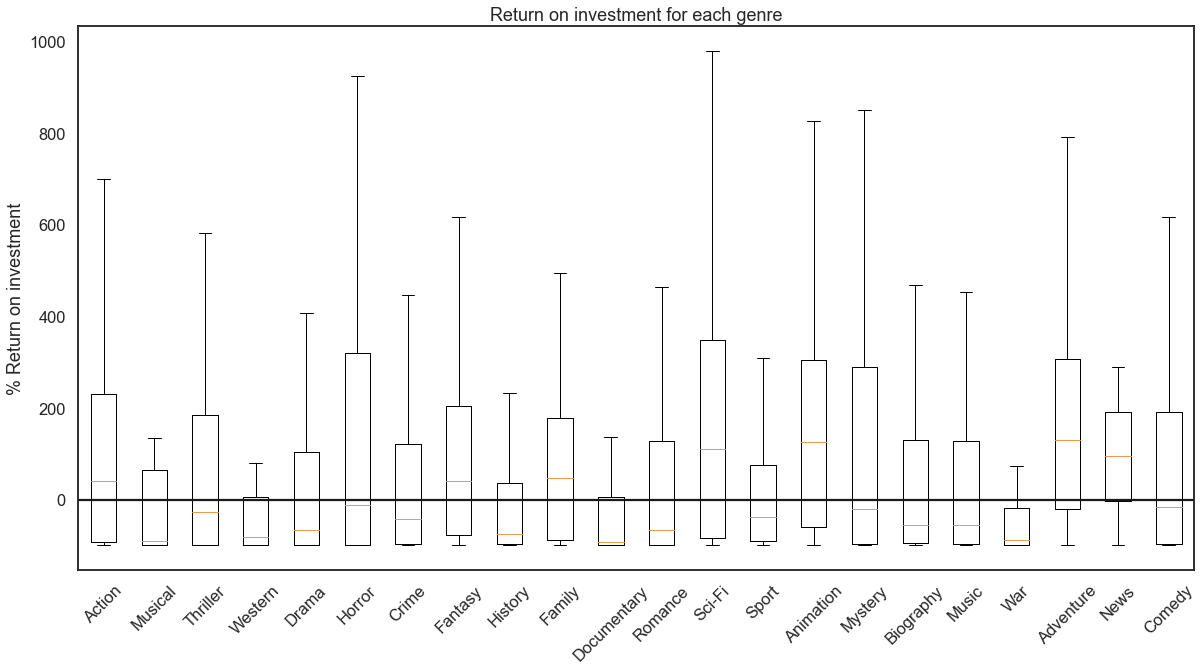

In [91]:
fig,ax = plt.subplots(figsize = (20,10))
ax.boxplot(genre_plot_roi,labels = [series.name for series in genre_plot_roi],showfliers=False);
ax.tick_params(axis='x',labelrotation=45)
fig.patch.set_facecolor('xkcd:white')
ax.axhline(y=0, color='k');
ax.set_title('Return on investment for each genre');
ax.set_ylabel('% Return on investment');

In [92]:
#genre_means = movies_df_from_top30.groupby(genre_set).mean().sort_values('clean_worldwide',ascending=False)
#genre_median = movies_df_from_top30.groupby('genres').median().sort_values('clean_worldwide',ascending=False)
#genre_median.head()
positive_world_profit = worldprofit_df[worldprofit_df['profit'] > 0].sort_values('profit', ascending = False)
positive_worldprofit_names = positive_world_profit['genres'].tolist()


We selected the top six genres and plotted them along the x-axis. We then plotted median gross measured in millions of USD on the y-axis of the barchart below. 
We chose to plot the median of the dataset instead of the mean because the dataset had some outliers that would not accurately represent the mean data.
This graph below is a representation of the Top 6 genres indicated by the box plot graph.

<ipython-input-93-c18fdc7f95af>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()//1000000);


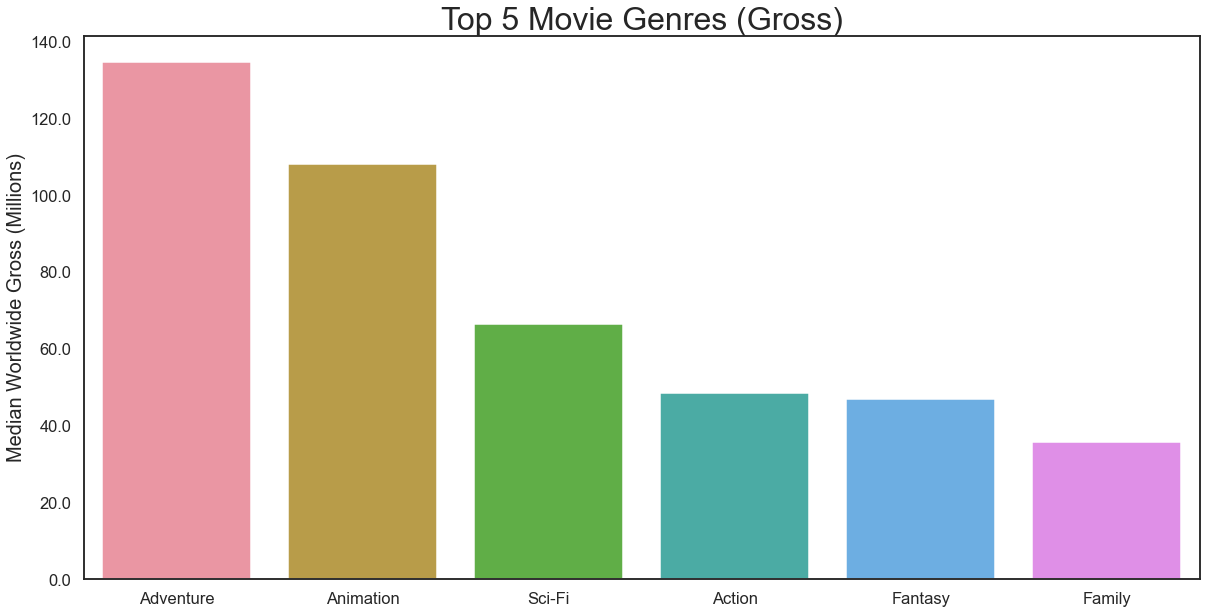

In [93]:
fig, ax = plt.subplots(figsize =(20,10))


sns.barplot(x = positive_worldprofit_names[:6], y = positive_world_profit['profit'][:6])
sns.set_theme(context = 'talk',style='white')
fig.patch.set_facecolor('xkcd:white')
# ax.set_xlabel('Movie Studios')
ax.set_title('Top 5 Movie Genres (Gross)', fontsize = 32)
ax.set_ylabel('Median Worldwide Gross (Millions)', fontsize = 20)
ax.set_yticklabels(ax.get_yticks()//1000000);

We also created a graph of the median profit per genre of movie. As you can see the profit data and the worldwide data share similar findings in that the highest grossing genre **AND** the most profitable genre is the Adventure genre.

In [94]:
positive_profit = profit_df[profit_df['profit'] > 0].sort_values('profit', ascending = False)
positive_profit_names = positive_profit['genres'].tolist()

<ipython-input-95-1e08e860c100>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()//1000000);


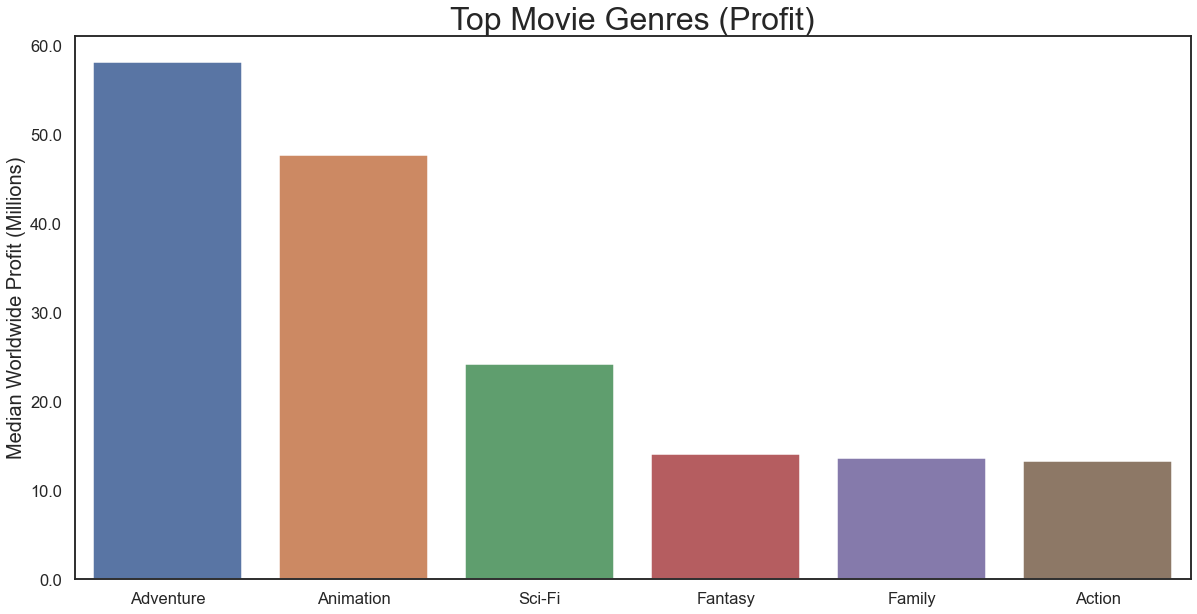

In [95]:
fig, ax = plt.subplots(figsize =(20,10))


sns.barplot(x = positive_profit_names[:6], y = positive_profit['profit'][:6])
sns.set_theme(context = 'talk',style='white')
fig.patch.set_facecolor('xkcd:white')
# ax.set_xlabel('Movie Studios')
ax.set_title('Top Movie Genres (Profit)', fontsize = 32)
ax.set_ylabel('Median Worldwide Profit (Millions)', fontsize = 20)
ax.set_yticklabels(ax.get_yticks()//1000000);

The boxplot below shows the profit data per movie genre. There are 5 movie genres that are easily distinguished as profitable genres: Adventure, Animation, Sci-Fi, Action, and Fantasy. These findings are similar to those of the graph above where we found that these were the same genres with the highest return on investment.

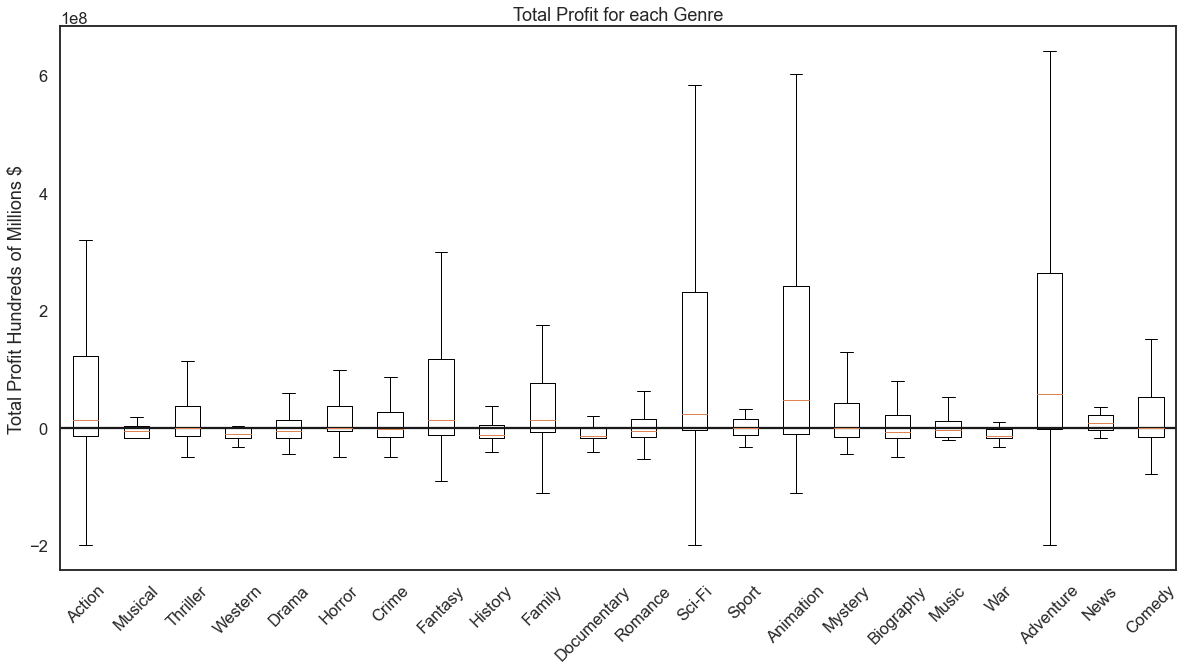

In [96]:
fig2,ax2 = plt.subplots(figsize = (20,10))
ax2.boxplot(genre_plot_profit,labels = [series.name for series in genre_plot_roi],showfliers=False);
ax2.tick_params(axis='x',labelrotation=45)
ax2.axhline(y=0, color='k');
ax2.set_title('Total Profit for each Genre');
ax2.set_ylabel('Total Profit Hundreds of Millions $');

## Studios
Next, we wanted to look at the studio competitors. We believe that understanding the success of Microsoft's competitiors and identifying their shortcomings will allow Microsoft to have an edge over the competition.

In [97]:
# Created new dataframes so that the original merged data set would still be intact.
studio_and_budget_df = all_movie_data
director_and_budget_df = all_movie_data

In [98]:
# Dropped any of the rows in the data frame where the studio column had any value that was NaN. 
# Dropped any of the rows in the director and budget data frame where the primary_name column had any NaN values
studio_and_budget_df[studio_and_budget_df['studio'].isna()]
studio_and_budget_df.dropna(subset=['studio'], inplace = True)
director_and_budget_df.dropna(subset=['primary_name'], inplace = True)

In [99]:
# Checked to see the amount of movies each studio made.
studio_and_budget_df['studio'].value_counts()[:30]

IFC        100
Magn.       86
SPC         66
Eros        66
Strand      49
KL          45
WGUSA       43
CJ          41
CL          39
UTV         36
MBox        35
Cohen       32
FM          31
RAtt.       31
Wein.       26
LGF         24
A24         21
FIP         18
Osci.       17
GK          16
BV          16
FoxS        16
Drft.       16
Gold.       15
Focus       14
Uni.        12
EOne        12
Zeit.       12
Sony        12
Relbig.     12
Name: studio, dtype: int64

In [100]:
# Created a list of the top_30_studio_names and created a new data frame where only the movies associated with the top 30 studios would be present.
top_30_studio_names = list(studio_and_budget_df['studio'].value_counts()[:30].index)
movies_df_from_top30 = studio_and_budget_df[studio_and_budget_df['studio'].isin(top_30_studio_names)]
movies_df_from_top30.head()

,movie_id,primary_title,genres,person_id,primary_name,death_year,title,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,studio,roi_domestic,roi_worldwide,clean_profit
2,tt0315642,Wazir,"Action,Crime,Drama",nm2349060,Bejoy Nambiar,NaN,Wazir,2016,NaN,17000000.0,1100000,0,1100000,Relbig.,-93.529412,-93.529412,-15900000.0
10,tt0376479,American Pastoral,"Crime,Drama",nm0000191,Ewan McGregor,NaN,American Pastoral,2016,NaN,17000000.0,544000,0,544000,LGF,-96.800000,-96.800000,-16456000.0
16,tt0409379,In Secret,"Crime,Drama,Thriller",nm0833627,Charlie Stratton,NaN,In Secret,2014,NaN,17000000.0,444000,0,444000,RAtt.,-97.388235,-97.388235,-16556000.0
17,tt0409847,Cowboys & Aliens,"Action,Sci-Fi,Thriller",nm0269463,Jon Favreau,NaN,Cowboys & Aliens,2011,NaN,17000000.0,100200000,74600000,174800000,Uni.,489.411765,928.235294,157800000.0
19,tt0420293,The Stanford Prison Experiment,"Biography,Drama,History",nm1547859,Kyle Patrick Alvarez,NaN,The Stanford Prison Experiment,2015,NaN,17000000.0,661000,0,661000,IFC,-96.111765,-96.111765,-16339000.0


In [101]:
# Created a studio_means and studio_median variable and assigned them their approrpiate statistical value.
studio_means = movies_df_from_top30.groupby('studio').mean().sort_values('clean_worldwide',ascending=False)
studio_median = movies_df_from_top30.groupby('studio').median().sort_values('clean_worldwide',ascending=False)
studio_means.head()

,death_year,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_domestic,roi_worldwide,clean_profit
studio,,,,,,,,
BV,NaN,17000000.0,1.042812e+08,1.489632e+08,2.532444e+08,513.419117,1389.673161,2.362444e+08
Uni.,NaN,17000000.0,6.435183e+07,1.369333e+08,2.012852e+08,278.540196,1084.030392,1.842852e+08
WGUSA,NaN,17000000.0,4.470163e+05,5.302435e+07,5.347137e+07,-97.370492,214.537442,3.647137e+07
LGF,NaN,17000000.0,1.362822e+07,2.790262e+07,4.153085e+07,-19.833971,144.299118,2.453085e+07
Sony,NaN,17000000.0,3.004333e+06,3.572500e+07,3.872933e+07,-82.327451,127.819608,2.172933e+07


In [102]:
studio_median.head()

,death_year,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_domestic,roi_worldwide,clean_profit
studio,,,,,,,,
Uni.,NaN,17000000.0,45750000,95600000,161950000,169.117647,852.647059,144950000.0
BV,NaN,17000000.0,30850000,93500000,131750000,81.470588,675.000000,114750000.0
Wein.,NaN,17000000.0,691000,9050000,14250000,-95.935294,-16.176471,-2750000.0
FIP,NaN,17000000.0,908000,11900000,12961000,-94.658824,-23.758824,-4039000.0
FoxS,NaN,17000000.0,3750000,3076000,9950000,-77.941176,-41.470588,-7050000.0


<ipython-input-103-bd6bdb641d14>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()//1000000);


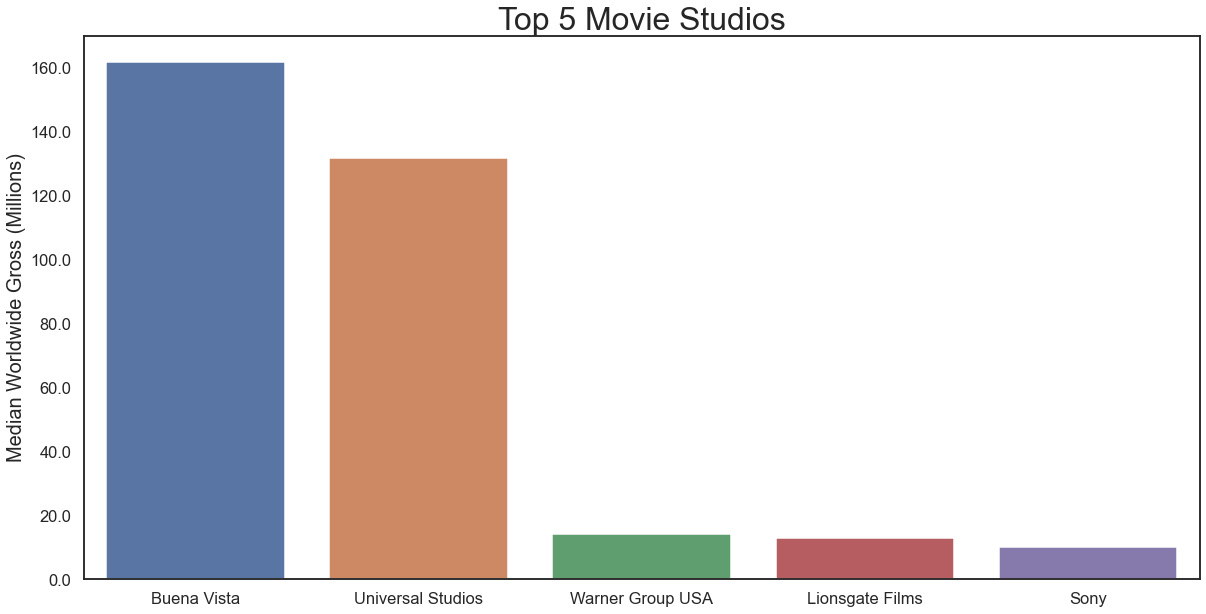

In [103]:
# Created a barplot visualization that showed the median worldwide gross.
fig, ax = plt.subplots(figsize =(20,10))


sns.barplot(x = ['Buena Vista', 'Universal Studios', 'Warner Group USA', 'Lionsgate Films', 'Sony'], y =studio_median['clean_worldwide'][:5])
sns.set_theme(context = 'talk',style='white')
fig.patch.set_facecolor('xkcd:white')
# ax.set_xlabel('Movie Studios')
ax.set_title('Top 5 Movie Studios', fontsize = 32)
ax.set_ylabel('Median Worldwide Gross (Millions)', fontsize = 20)
ax.set_yticklabels(ax.get_yticks()//1000000);

<ipython-input-104-9baf3c2c55e5>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()//1000000);


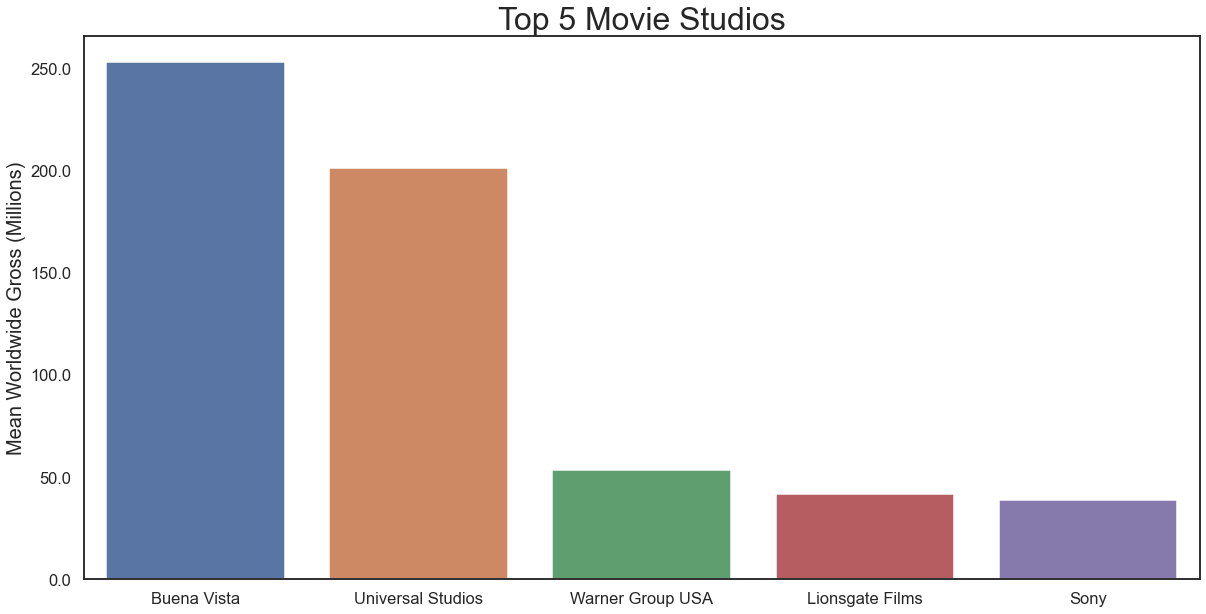

In [104]:
# # Created a barplot visualization that showed the mean worldwide gross.
fig, ax = plt.subplots(figsize =(20,10))


sns.barplot(x = ['Buena Vista', 'Universal Studios', 'Warner Group USA', 'Lionsgate Films', 'Sony'], y =studio_means['clean_worldwide'][:5])
sns.set_theme(context = 'talk',style='white')
fig.patch.set_facecolor('xkcd:white')
# ax.set_xlabel('Movie Studios')
ax.set_title('Top 5 Movie Studios', fontsize = 32)
ax.set_ylabel('Mean Worldwide Gross (Millions)', fontsize= 20)
ax.set_yticklabels(ax.get_yticks()//1000000);

We can see here that based on the data given to us these were the Top 5 Movie Studio competitors. This is the competition that Microsoft must be aware of when considering to break into the industry. These competitors have clearly done something right to be making this much gross profit after all these years. It’s good to know who Microsoft is going to be up against when they’re on the way to the top, and since these competitors are well established, they will be good benchmarks for measures of success. Microsoft should analyze the work of these competitors to identify what had the best public reception and find solutions to their shortcomings in order to maximize your profit.

## Seasons

Next we looked at the release timing of the movies in the datasets to see if there was a correlation between release date and higher profit.

In [105]:
# Created a function called season_category that filtered the months into specific season categories.
def season_category(month):
    if month in ['Dec', 'Jan', 'Feb']:
        return 'Winter'
    elif month in ['Mar', 'Apr', 'May']:
        return  'Spring'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Summer'
    else:
        return 'Autumn'

In [106]:
# Applied the season_category formula to the month columns in the tn_relevant database then created a new column called Seasons to filter and organize the new outputs.
tn_relevant['Seasons'] = tn_relevant['month'].apply(season_category)


<ipython-input-106-5ed34b7a63dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_relevant['Seasons'] = tn_relevant['month'].apply(season_category)


In [ ]:
# Imported necessary libraries to visualize different colors to use for the graphs that we generated using Seaborne.
from pylab import *
from numpy import outer
rc('text', usetex=False)
a=outer(arange(0,1,0.01),ones(10))
figure(figsize=(10,5))
subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
maps=[m for m in cm.datad if not m.endswith("_r")]
maps.sort()
l=len(maps)+1
for i, m in enumerate(maps):
     subplot(1,l,i+1)
     axis("off")
     imshow(a,aspect='auto',cmap=get_cmap(m),origin="lower")
     title(m,rotation=90,fontsize=10)
savefig("colormaps.png",dpi=100,facecolor='gray')

In [ ]:
# Ordered the months by how they appear in the calendar
# Created a bar plot to show the median earnings per month. We then organized the monthly earnings into seasonal categories to create a visualization that was easier to digest.
months_in_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tn_plot_month = tn_relevant.groupby('month').agg(median_earning=('clean_worldwide','median'))
tn_plot_month= tn_plot_month.reset_index()
sns.set(rc = {'figure.figsize':(15,8)});
sns.set_theme(context = 'talk',style='white');
ax4 = sns.barplot(x='month',y='median_earning',data=tn_plot_month,order=months_in_order)
ax4.set_ylabel('Median Worldwide Gross (Millions)');
ax4.set_xlabel(None);
ax4.set_title('Median Earnings per Month',fontsize=32);
ax4.set_yticklabels(ax4.get_yticks()//1000000);

In [ ]:
# Used hex values for the colors in order to accurately reflect the color of the seasons
colors = ["#348781","#EE9A4D","#931314","#4863A0" ]
sns.set_palette(sns.color_palette(colors))
seasons_in_order = ['Spring','Summer','Autumn','Winter']
tn_plot_season = tn_relevant.groupby('Seasons').agg(median_earning=('clean_worldwide','median'))
tn_plot_season= tn_plot_season.reset_index()
sns.set(rc = {'figure.figsize':(15,8)});
sns.set_theme(context = 'talk',style='white');
sns.set_palette(sns.color_palette(colors));
ax4 = sns.barplot(x='Seasons',y='median_earning',data=tn_plot_season,order=seasons_in_order)
ax4.set_ylabel('Median Worldwide Gross (Millions)');
ax4.set_xlabel(None);
ax4.set_title('Median Worldwide Gross per Season',fontsize=32);
ax4.set_yticklabels(ax4.get_yticks()//1000000);

We found that movies released during the Summer season tend to have a higher profit than those released in other seasons. With this data, Microsoft should aim to create and produce a movie that should aim to be released during the summer time. If the summer time movie release is not plausible, then releasing a movie during the winter would be a good backup.

# Conclusion

We believe that this analysis suggests these courses of action for Microsoft moving forward. 

* We recommend that Microsoft utilize their readily available resources and beloved IPs. The Halo franchise is a good place to start since it is already widely popular and embodies three of the top-performing genres - **Action, Adventure, and Scifi.** (not to mention their new recently acquired IPs from their merge with Activision Blizzard)

* **Buena Vista**(now known as Walt Disney Motion Picture Studio) **is Microsoft's biggest competitor**. They focus primarily on **family animation** movies, so it may be in Microsoft's best interest to avoid making movies of that genre and play to the strengths of their established Adventure/Sci-Fi IPs. 

* **Releasing the movie during the summer time** would bring in the highest revenue compared to releasing the movie during other seasons.  

# Future considerations:

* **Return on investment could be a more important figure to Microsoft than profit values alone**. Given their recent 68 Billion Dollar investment with the merge of Activision Blizzard, Microsoft has made a big investment, and they're hoping for big returns. Given more time and a more complete budget dataset, we would be able to confidently draw some conclusions using this metric

* The next question we would dive into is: **who is the best director for the highest profitable genre?** Micrsoft could look into hiring well known directors, for example, someone like Tim Burton who has an expansive record in directing animation and adventure/fantasy films (Nightmare Before Christmas and Alice in Wonderland). 

* We could also look at data to **help Microsoft wabreak into at an international movie market**. A lot of the directors in this dataset are international movie directors like Bong Joon-Ho. He directed the hit movie Parasite in 2019 that had a phenomenal international reception, and so it may be worth it to consider looking into these directors if Microsoft wants to reach a broader audience.
